# January, 10th 2020

**Motivation**: Simulation to understand Partial Least Squares (PLS) and Canonical Correlation Analysis CCA.<br>
**Result**: These methods detect the shared, low-dimensional latent signal in linear, simulated data.

In [1]:
# HIDE CODE


# imports
import os
import sys
import h5py
import pickle
import random
import numpy as np
import pandas as pd
from os.path import join as pjoin
from copy import deepcopy as dc
from tqdm.notebook import tqdm
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

github_path = pjoin(os.environ['HOME'], 'Dropbox/git/A1ToneDiscrimination/')
sys.path.insert(0, github_path)
from utils.process import *
from utils.generic_utils import *
from utils.plot_functions import *

import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)

import rcca
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import balanced_accuracy_score, matthews_corrcoef, f1_score

SEED = 42
np.random.seed(SEED)
random.seed(SEED)

# load data
# dirs_dict = get_dirs()

## Random projection to higher dim space

In [2]:
from tqdm.notebook import tqdm
from scipy import spatial
from scipy.stats import pearsonr
from numpy.linalg import norm
from sklearn.metrics import r2_score
from sklearn.preprocessing import normalize


# --------------------------- plotting functions ---------------------------


def visualize_pls_results(pls, sim, verbose: bool = False):
    _print_sim_info(sim, verbose)
    avg_latent_corrs, pred_r2 = _plot_latent_retreival(pls, sim, verbose)
    avg_proj_corrs = _plot_similarity_matrix(pls, sim, verbose)
    avg_error = _print_results(pls, sim, verbose)
    
    results = {
        'latent_corr': avg_latent_corrs,
        'proj_corr': avg_proj_corrs,
        'error': avg_error,
        'pred_r2': pred_r2,
    }
    return results
    
def _print_sim_info(sim, verbose):
    if not verbose:
        return
    
    metadata = sim['metadata']
    msg = 'Simulation info:\n\n'
    msg += 'num samples:\t{:.0e},\nnoise sigma:\t{:.1f},\ndim Z:\t{:d},\ndim X:\t{:d},\ndim Y:\t{:d}'
    msg = msg.format(
        metadata['n_samples'],
        metadata['sigma'],
        metadata['dim_z'],
        metadata['dim_x'],
        metadata['dim_y'],)
    print(msg)
    print('\n\n')


def _plot_latent_retreival(pls, sim, verbose):
    T, U = pls.transform(sim['x_test'], sim['y_test'])
    y_pred = pls.predict(sim['x_test'])
    pred_r2 = r2_score(sim['y_test'], y_pred, multioutput='raw_values') * 100
    pred_r2 = np.maximum(0.0, pred_r2).mean()
    
    dim_z = sim['metadata']['dim_z']
    x_indxs, y_indxs = {}, {}
    for i in range(dim_z):
        current_x_idx = i
        current_y_idx = i
        current_x_corr = 0.0
        current_y_corr = 0.0
        for j in range(dim_z):
            _corr_x = abs(pearsonr(sim['z_test'][:, i], T[:, j])[0])
            _corr_y = abs(pearsonr(sim['z_test'][:, i], U[:, j])[0])

            if _corr_x > current_x_corr:
                current_x_corr = _corr_x
                current_x_idx = j
            if _corr_y > current_y_corr:
                current_y_corr = _corr_y
                current_y_idx = j

        x_indxs[i] = current_x_idx
        y_indxs[i] = current_y_idx
    
    for i in range(dim_z):
        if pearsonr(T[:, x_indxs[i]], sim['z_test'][:, i])[0] < 0.0:
            T[:, x_indxs[i]] *= -1
        if pearsonr(U[:, y_indxs[i]], sim['z_test'][:, i])[0] < 0.0:
            U[:, y_indxs[i]] *= -1

    if verbose:
        sns.set_style('whitegrid')
        plt.figure(figsize=(12, 6))

        plt.subplot(121)
        plt.plot(T[:30, x_indxs[0]], label='X')
        plt.plot(U[:30, y_indxs[0]], label='Y')
        plt.plot(sim['z_test'][:30, 0], 'k--', lw=2, label='true')
        plt.xlabel('samples')
        plt.title('1st dim')

        plt.subplot(122)
        plt.plot(T[:30, x_indxs[1]], label='X')
        plt.plot(U[:30, y_indxs[1]], label='Y')
        plt.plot(sim['z_test'][:30, 1], 'k--', lw=2, label='true')
        plt.xlabel('samples')
        plt.title('2nd dim')

        msg = 'correlation with source signal:\n'
        msg += 'X  -->   1st dim:  {:.2f}  ,  2nd dim:  {:.2f}\n'
        msg += 'Y  -->   1st dim:  {:.2f}  ,  2nd dim:  {:.2f}\n\n'
        msg += 'percent variance of Y explained (predicted useing X):   {:.0f} {:s}\n\n'
        msg += 'figure showing latent and retreived signals over a few samples\n'
        msg = msg.format(
            pearsonr(T[:, x_indxs[0]], sim['z_test'][:, 0])[0],
            pearsonr(T[:, x_indxs[1]], sim['z_test'][:, 1])[0],
            pearsonr(U[:, y_indxs[0]], sim['z_test'][:, 0])[0],
            pearsonr(U[:, y_indxs[1]], sim['z_test'][:, 1])[0],
            pred_r2, '%',
        )
        plt.suptitle(msg, fontsize=15)

        plt.legend()
        plt.tight_layout()
        plt.show()
        print('\n\n')
    
    corrs_x = [pearsonr(T[:, x_indxs[i]], sim['z_test'][:, i])[0] for i in range(dim_z)]
    corrs_y = [pearsonr(U[:, y_indxs[i]], sim['z_test'][:, i])[0] for i in range(dim_z)]
    
    return np.mean(corrs_x + corrs_y), pred_r2


def _plot_similarity_matrix(pls, sim, verbose):
    dim_z = sim['metadata']['dim_z']
    cos_sim_x = np.zeros((dim_z, dim_z))
    cos_sim_y = np.zeros((dim_z, dim_z))

    for i in range(dim_z):
        for j in range(dim_z):
            cos_sim_x[i, j] = cos_similarity(sim['P'][:, i], pls.x_loadings_[:, j])
            cos_sim_y[i, j] = cos_similarity(sim['Q'][:, i], pls.y_loadings_[:, j])

    if verbose:
        sns.set_style('white')
        plt.figure(figsize=(6, 3))
        plt.subplot(121)
        plt.imshow(cos_sim_x, cmap='bwr', vmin=-1, vmax=1)
        plt.xticks(range(dim_z))
        plt.yticks(range(dim_z))
        plt.title('X')
        plt.colorbar()
        plt.subplot(122)
        plt.imshow(cos_sim_y, cmap='bwr', vmin=-1, vmax=1)
        plt.xticks(range(dim_z))
        plt.yticks(range(dim_z))
        plt.title('Y')
        plt.colorbar()

        msg = 'cosine similarity between true and retreived projection vectors\n'
        msg += 'rows correspond to true, and columns correspond to retreived\n'
        msg += 'i.e. element $ij$ means cos sim between $P_i$ and $j$-th retreived loading vector'
        plt.suptitle(msg, fontsize=15)
        plt.tight_layout()
        plt.show()

        print('matrix values:\n\nX:\n{}\n\nY:\n{}'.format(cos_sim_x, cos_sim_y))
        print('\n\n')
    
    avg_corr_x = np.max(np.abs(cos_sim_x), axis=0).mean()
    avg_corr_y = np.max(np.abs(cos_sim_y), axis=0).mean()
    return np.mean([avg_corr_x, avg_corr_y])

    
def _print_results(pls, sim, verbose):
    dim_y = sim['y_test'].shape[1]
    test_corrs = np.zeros(dim_y)
    y_pred = pls.predict(sim['x_test'])

    for j in range(dim_y):
        r, p_val = pearsonr(y_pred[:, j], sim['y_test'][:, j])
        test_corrs[j] = r
    error = 1 - np.mean(test_corrs)

    if verbose:
        msg = 'Angle between true projection vectors:\n'
        msg += 'X:  {:.1f} degrees,   Y:  {:.1f} degrees\n\n'
        msg += 'Angle between retreived loading vectors:\n'
        msg += 'X:  {:.1f} degrees,   Y:  {:.1f} degrees\n\n'

        msg += 'error = 1 - mean correlation between true and predicted (Y predicted from X):\n'
        msg += 'error = {:.2e}'

        msg = msg.format(
            np.rad2deg(np.arccos(cos_similarity(sim['P'][:, 0], sim['P'][:, 1]))),
            np.rad2deg(np.arccos(cos_similarity(sim['Q'][:, 0], sim['Q'][:, 1]))),
            np.rad2deg(np.arccos(cos_similarity(pls.x_loadings_[:, 0], pls.x_loadings_[:, 1]))),
            np.rad2deg(np.arccos(cos_similarity(pls.y_loadings_[:, 0], pls.y_loadings_[:, 1]))),
            error,)
        print(msg)

    return error


# --------------------------- sim functions ---------------------------

def cos_similarity(I, II):
    return 1 - spatial.distance.cosine(I, II)


def orthonormalize(x):
    a = x[:, 0]
    b = x[:, 1]
    b_orth = b - (np.dot(a, b) / np.dot(a, a)) * a
    x_orth = np.array([a, b_orth]).T
    return normalize(x_orth, axis=0)


def get_source_signal(n_samples, rng=None):
    if rng is None:
        rng = np.random.RandomState(42)

    thetas = rng.choice(np.arange(360), size=n_samples, replace=True)
    thetas = np.deg2rad(thetas)
    z_train = np.array([np.cos(thetas), np.sin(thetas)]).T

    thetas = rng.choice(np.arange(360), size=n_samples, replace=True)
    thetas = np.deg2rad(thetas)
    z_test = np.array([np.cos(thetas), np.sin(thetas)]).T
    
    return z_train, z_test


def create_pls_simulation(
    z_train=None,
    z_test=None,
    n_samples: int = int(1e3),
    dim_x: int = 16,
    dim_y: int = 8,
    sigma: float = 0.0,
    orthonormal: bool = False,
    seed: int = 42,):
    
    rng = np.random.RandomState(seed)
    if z_train is None or z_test is None:
        z_train, z_test = get_source_signal(n_samples, rng)

    P = rng.randn(dim_x, 2)
    Q = rng.randn(dim_y, 2)
    if orthonormal:
        P, Q = tuple(map(orthonormalize, [P, Q]))
    
    E = rng.randn(n_samples, dim_x) * sigma
    F = rng.randn(n_samples, dim_y) * sigma

    x_train = z_train @ P.T + E
    y_train = z_train @ Q.T + F

    x_test = z_test @ P.T + E
    y_test = z_test @ Q.T + F
    
    metadata = {
        'n_samples': n_samples,
        'dim_z': 2,
        'dim_x': dim_x,
        'dim_y': dim_y,
        'sigma': sigma,
        'orthonormal': orthonormal,
        'seed': seed,
    }
    output = {
        'x_train': x_train,
        'x_test': x_test,
        'y_train': y_train,
        'y_test': y_test,
        'z_train': z_train,
        'z_test': z_test,
        'P': P,
        'Q': Q,
        'E': E,
        'F': F,
        'metadata': metadata,
    }
    return output


def create_cca_simulation(
    z_train=None,
    z_test=None,
    num_expts: int = 32,
    min_num_cells: int = 16,
    max_num_cells: int = 128,
    n_samples: int = int(1e3),
    sigma: float = 0.1,
    seed: int = 42,):
    
    rng = np.random.RandomState(seed)
    if z_train is None or z_test is None:
        z_train, z_test = get_source_signal(n_samples, rng)
  
    dims = rng.choice(range(min_num_cells, max_num_cells), size=num_expts, replace=True)  
    proj_mats = [rng.randn(d, 2) for d in dims]
    x_train = [z_train @ P.T + rng.randn(n_samples, d) * sigma for P, d in zip(proj_mats, dims)]
    x_test = [z_test @ P.T + rng.randn(n_samples, d) * sigma for P, d in zip(proj_mats, dims)]

    metadata = {
        'n_samples': n_samples,
        'dim_z': 2,
        'num_expts': num_expts,
        'min_num_cells': min_num_cells,
        'max_num_cells': max_num_cells,
        'dims': dims,
        'sigma': sigma,
        'seed': seed,
    }
    output = {
        'x_train': x_train,
        'x_test': x_test,
        'z_train': z_train,
        'z_test': z_test,
        'proj_mats': proj_mats,
        'metadata': metadata,
    }
    return output

## SIM

In [11]:
n_samples = int(1e3)
dim_x, dim_y = 8, 8
sigma = 0.0

sim = create_pls_simulation(
    n_samples=n_samples,
    dim_x=dim_x,
    dim_y=dim_y,
    sigma=sigma,
    orthonormal=False,
    seed=SEED,
)

## PLS

In [12]:
from sklearn.cross_decomposition import PLSCanonical

pls = PLSCanonical(
    n_components=2,
    scale=True,
    algorithm='svd',
    max_iter=int(1e9),
    tol=1e-15,
).fit(sim['x_train'], sim['y_train'])

Simulation info:

num samples:	1e+03,
noise sigma:	0.0,
dim Z:	2,
dim X:	8,
dim Y:	8





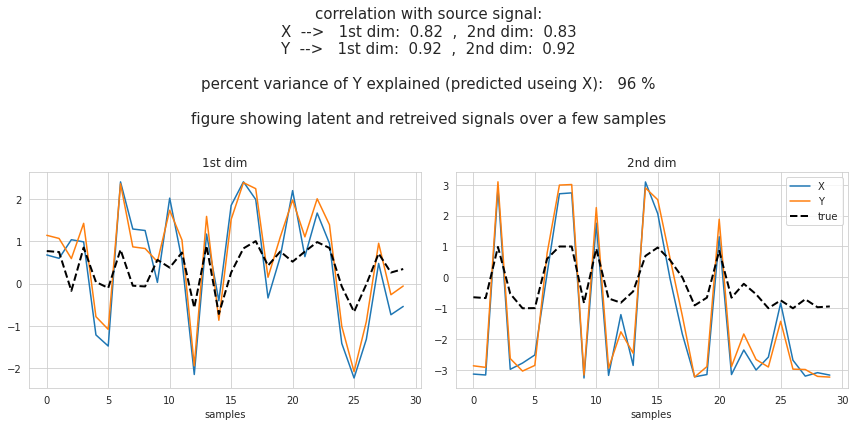

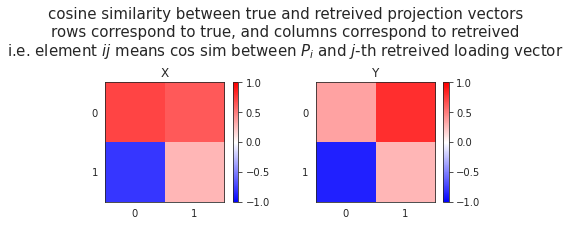

matrix values:

X:
[[ 0.73326892  0.64281982]
 [-0.7850375   0.2824664 ]]

Y:
[[ 0.36070002  0.81290917]
 [-0.86790911  0.28814885]]



Angle between true projection vectors:
X:  118.4 degrees,   Y:  100.4 degrees

Angle between retreived loading vectors:
X:  81.3 degrees,   Y:  98.8 degrees

error = 1 - mean correlation between true and predicted (Y predicted from X):
error = 2.09e-02


In [13]:
results = visualize_pls_results(pls, sim, verbose=True)

In [14]:
results

{'latent_corr': 0.8749135560441331,
 'proj_corr': 0.7771689023019858,
 'error': 0.020937563698197437,
 'pred_r2': 95.78312218503963}

### LOOP

In [15]:
from tqdm.notebook import tqdm

In [16]:
start = 1
stop = 4

dims = np.logspace(start, stop, num=stop-start+1, base=4, dtype=int)
dims

array([  4,  16,  64, 256])

In [130]:
n_samples = int(1e5)
n_seeds = 30
sigma = 0.0
orthogonal = False

z_train, z_test = get_source_signal(n_samples)

df = pd.DataFrame()
for seed in tqdm([int(2 ** i) for i in range(n_seeds)]):
    for dim_x in tqdm(dims, leave=False):
        for dim_y in tqdm(dims, leave=False):
            # create sim
            sim = create_pls_simulation(
                z_train=z_train,
                z_test=z_test,
                n_samples=n_samples,
                dim_x=dim_x,
                dim_y=dim_y,
                sigma=sigma,
                orthonormal=orthogonal,
                seed=seed,
            )
            # fit PLS
            pls = PLSCanonical(
                n_components=2,
                scale=True,
                algorithm='svd',
                max_iter=int(1e9),
                tol=1e-15,
            ).fit(sim['x_train'], sim['y_train'])
            # get results
            results = visualize_pls_results(pls, sim, verbose=False)
            results.update(
                {'seed': seed,
                 'dim_x': dim_x,
                 'dim_y': dim_y,
                 'n_samples': n_samples,
                 'sigma': sigma,
                 'orthogonal': orthogonal,
                })
            results = {k: [v] for k, v in results.items()}
            df = pd.concat([df, pd.DataFrame.from_dict(results)])
df = reset_df(df)

In [131]:
errors = np.zeros((len(dims), len(dims)))
pred_r2s = np.zeros((len(dims), len(dims)))
latent_corrs = np.zeros((len(dims), len(dims)))
proj_corrs = np.zeros((len(dims), len(dims)))

for i, dim_x in enumerate(dims):
    for j, dim_y in enumerate(dims):
        selected_df = df.loc[(df.dim_x == dim_x) & (df.dim_y == dim_y)]
        errors[i, j] = selected_df.error.mean()
        pred_r2s[i, j] = selected_df.pred_r2.mean()
        latent_corrs[i, j] = selected_df.latent_corr.mean()
        proj_corrs[i, j] = selected_df.proj_corr.mean()

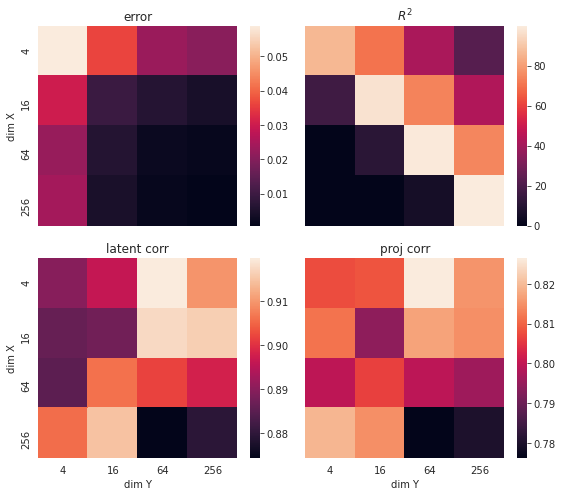

In [132]:
fig, axes = plt.subplots(2, 2, figsize=(8, 7), sharex='all', sharey='all')

sns.heatmap(errors, xticklabels=dims, yticklabels=dims, ax=axes[0, 0])
sns.heatmap(pred_r2s, xticklabels=dims, yticklabels=dims, ax=axes[0, 1])
sns.heatmap(latent_corrs, xticklabels=dims, yticklabels=dims, ax=axes[1, 0])
sns.heatmap(proj_corrs, xticklabels=dims, yticklabels=dims, ax=axes[1, 1])

axes[0, 0].set_title('error')
axes[0, 1].set_title('$R^2$')
axes[1, 0].set_title('latent corr')
axes[1, 1].set_title('proj corr')

axes[0, 0].set_ylabel('dim X')
axes[1, 0].set_ylabel('dim X')
axes[1, 0].set_xlabel('dim Y')
axes[1, 1].set_xlabel('dim Y')

fig.tight_layout()
plt.show()

In [68]:
n_seeds = 30
seeds = [int(2 ** i) for i in range(n_seeds)]
num_samples = np.logspace(1, 4, num=4, dtype=int)

sigma = 0.1
dim_x = 4
dim_y = 8
orthogonal = False

df = pd.DataFrame()
for n_samples in tqdm(num_samples):
    for seed in tqdm(seeds, leave=False):
        # create sim
        sim = create_pls_simulation(
            n_samples=n_samples,
            dim_x=dim_x,
            dim_y=dim_y,
            sigma=sigma,
            orthonormal=orthogonal,
            seed=seed,
        )
        # fit PLS
        pls = PLSCanonical(
            n_components=2,
            scale=True,
            algorithm='svd',
            max_iter=int(1e9),
            tol=1e-15,
        ).fit(sim['x_train'], sim['y_train'])
        # get results
        results = visualize_pls_results(pls, sim, verbose=False)
        results.update(
            {'seed': seed,
             'dim': dim,
             'n_samples': n_samples,
             'sigma': sigma,
             'orthogonal': orthogonal,
            })
        results = {k: [v] for k, v in results.items()}
        df = pd.concat([df, pd.DataFrame.from_dict(results)])
df = reset_df(df)

<AxesSubplot:xlabel='n_samples', ylabel='pred_r2'>

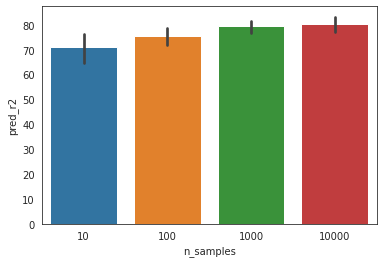

In [69]:
sns.barplot(x='n_samples', y='pred_r2', data=df)

In [92]:
n_seeds = 10
seeds = [int(2 ** i) for i in range(n_seeds)]
n_samples = int(1e2)
# num_samples = np.logspace(1, 4, num=4, dtype=int)

sigma = 0.1
orthogonal = False

df = pd.DataFrame()
for dim_x in tqdm([2, 4, 8, 16, 32, 128]):
    for seed in tqdm(seeds, leave=False):
        # create sim
        dim_y = dim_x
        sim = create_pls_simulation(
            n_samples=n_samples,
            dim_x=dim_x,
            dim_y=dim_y,
            sigma=sigma,
            orthonormal=orthogonal,
            seed=seed,
        )
        # fit PLS
        pls = PLSCanonical(
            n_components=2,
            scale=True,
            algorithm='svd',
            max_iter=int(1e9),
            tol=1e-15,
        ).fit(sim['x_train'], sim['y_train'])
        # get results
        results = visualize_pls_results(pls, sim, verbose=False)
        results.update(
            {'seed': seed,
             'dim': dim_x,
             'n_samples': n_samples,
             'sigma': sigma,
             'orthogonal': orthogonal,
            })
        results = {k: [v] for k, v in results.items()}
        df = pd.concat([df, pd.DataFrame.from_dict(results)])
df = reset_df(df)

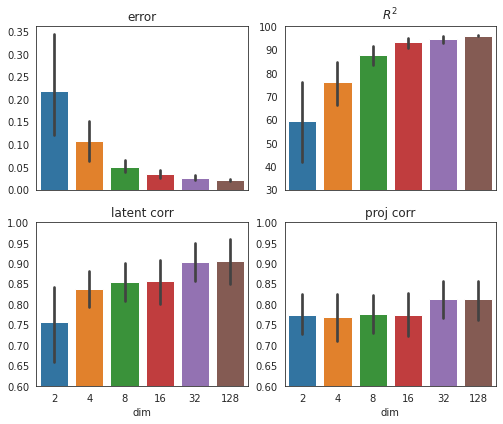

In [109]:
fig, axes = plt.subplots(2, 2, figsize=(7, 6), sharex='all')

sns.barplot(x='dim', y='error', data=df, ax=axes[0, 0])
sns.barplot(x='dim', y='pred_r2', data=df, ax=axes[0, 1])
sns.barplot(x='dim', y='latent_corr', data=df, ax=axes[1, 0])
sns.barplot(x='dim', y='proj_corr', data=df, ax=axes[1, 1])

axes[0, 1].set_ylim(30, 100)
axes[1, 0].set_ylim(0.6, 1.0)
axes[1, 1].set_ylim(0.6, 1.0)

axes[0, 0].set_title('error')
axes[0, 1].set_title('$R^2$')
axes[1, 0].set_title('latent corr')
axes[1, 1].set_title('proj corr')

axes[0, 0].set_xlabel('')
axes[0, 1].set_xlabel('')
axes[1, 0].set_xlabel('dim')
axes[1, 1].set_xlabel('dim')

axes[0, 0].set_ylabel('')
axes[0, 1].set_ylabel('')
axes[1, 0].set_ylabel('')
axes[1, 1].set_ylabel('')

fig.tight_layout()
plt.show()

## CCA

In [101]:
import rcca

sim = create_cca_simulation(
    num_expts=10,
    min_num_cells=16,
    max_num_cells=128,
    n_samples=int(1e2),
    sigma=0.2,
    seed=42,)
cca = rcca.CCA(kernelcca=True, ktype='linear', reg=0.1, numCC=2)
cca.train(sim['x_train'])

Training CCA, kernel = linear, regularization = 0.1000, 2 components


In [102]:
testcorrs = cca.validate(sim['x_test'])
mean_corr = np.mean([item.mean() for item in testcorrs])
error = 1 - mean_corr

mean_corr

0.9331603516950004

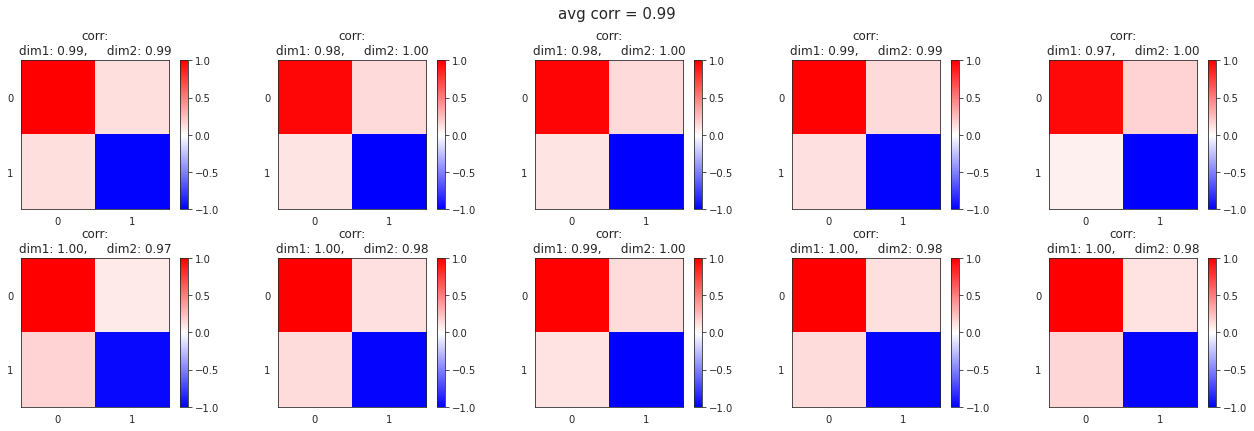

In [105]:
plt.figure(figsize=(18, 6))

corrs_all = []
for c in range(10):
    cos_sim = np.zeros((2, 2))
    for i in range(2):
        for j in range(2):
            cos_sim[i, j] = cos_similarity(sim['proj_mats'][c][:, i], cca.ws[c][:, j])
    _corrs = np.max(np.abs(cos_sim), axis=0)
    corrs_all.append(np.mean(_corrs))

    plt.subplot(2, 5, c+1)
    plt.imshow(cos_sim, cmap='bwr', vmin=-1, vmax=1)
    plt.xticks(range(2))
    plt.yticks(range(2))
    plt.colorbar()
    msg = 'corr:\ndim1: {:.2f},     dim2: {:.2f}'
    msg = msg.format(*_corrs)
    plt.title(msg)

plt.suptitle('avg corr = {:.2f}'.format(np.mean(corrs_all)), fontsize=15)
plt.tight_layout()
plt.show()

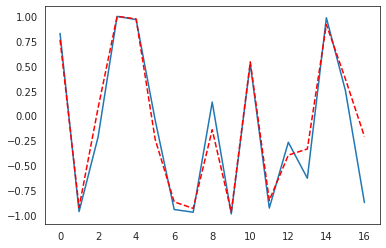

In [96]:
a = sim['proj_mats'][c]
b = cca.ws[c]

plt.plot(normalize(a)[:, 0])
plt.plot(normalize(b)[:, 0], 'r--')

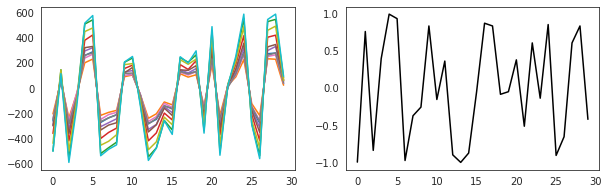

In [126]:
plt.figure(figsize=(10, 3))

plt.subplot(121)
for c in cca.comps:
    plt.plot(c[:30, 0])

plt.subplot(122)
plt.plot(sim['z_train'][:30, 1], c='k')

In [127]:

c = 3
pearsonr(sim['z_train'][:, 1], cca.comps[c][:, 1])[0]

-0.5288430574211993

0.8268262093049794

In [ ]:
sim = create_cca_simulation(
    num_expts=10,
    min_num_cells=16,
    max_num_cells=128,
    n_samples=int(1e2),
    sigma=0.2,
    seed=42,)
cca = rcca.CCA(kernelcca=True, ktype='linear', reg=0.1, numCC=2)
cca.train(sim['x_train'])

## LOOP

In [155]:
n_seeds = 20
seeds = [int(2 ** i) for i in range(n_seeds)]
n_samples = int(1e2)
sigma = 0.1

min_ncs = [2, 4, 8, 16, 32, 64]
max_ncs = [32, 64, 256, 1024, 2048]

df = pd.DataFrame()
for seed in tqdm(seeds):
    z_train, z_test = get_source_signal(n_samples, np.random.RandomState(seed))
    for min_num_cells in tqdm(min_ncs, leave=False):
        for max_num_cells in tqdm([item for item in max_ncs if item > min_num_cells], leave=False):
            
            # create sim
            sim = create_cca_simulation(
                z_train=z_train,
                z_test=z_test,
                num_expts=10,
                min_num_cells=min_num_cells,
                max_num_cells=max_num_cells,
                n_samples=n_samples,
                sigma=sigma,
                seed=seed,
            )
            
            # fit cca
            cca = rcca.CCA(kernelcca=True, ktype='linear', reg=0.1, numCC=2, verbose=False)
            cca.train(sim['x_train'])

            # get avg error
            testcorrs = cca.validate(sim['x_test'])
            mean_corr = np.mean([item.mean() for item in testcorrs])
            error = 1 - mean_corr
        
            # get avg proj corr
            corrs_all = []
            for c in range(10):
                cos_sim = np.zeros((2, 2))
                for i in range(2):
                    for j in range(2):
                        cos_sim[i, j] = cos_similarity(sim['proj_mats'][c][:, i], cca.ws[c][:, j])
                _corrs = np.max(np.abs(cos_sim), axis=0)
                corrs_all.append(np.mean(_corrs))
            avg_proj_corr = np.mean(corrs_all)
            
            # get avg latent corr
            latent_corrs = []
            for comp in cca.comps:
                _corrs = np.abs(
                    [pearsonr(sim['z_train'][:, i], comp[:, j])[0]
                     for i in range(2) for j in range(2)]
                )
                _idxs = np.argsort(_corrs)
                latent_corrs.append(np.mean(_corrs[_idxs[-2:]]))
            avg_latent_corr = np.mean(latent_corrs)
            
            results = {
                'seed': [seed],
                'error': [error],
                'proj_corr': [avg_proj_corr],
                'latent_corr': [avg_latent_corr],
                'min_num_cells': [min_num_cells],
                'max_num_cells': [max_num_cells],
            }
            df = pd.concat([df, pd.DataFrame.from_dict(results)])
df = reset_df(df)

In [156]:
errors = np.zeros((len(min_ncs), len(max_ncs)))
latent_corrs = np.zeros((len(min_ncs), len(max_ncs)))
proj_corrs = np.zeros((len(min_ncs), len(max_ncs)))

for i, min_num_cells in enumerate(min_ncs):
    for j, max_num_cells in enumerate(max_ncs):
        selected_df = df.loc[(df.min_num_cells == min_num_cells) & (df.max_num_cells == max_num_cells)]
        errors[i, j] = selected_df.error.mean()
        latent_corrs[i, j] = selected_df.latent_corr.mean()
        proj_corrs[i, j] = selected_df.proj_corr.mean()

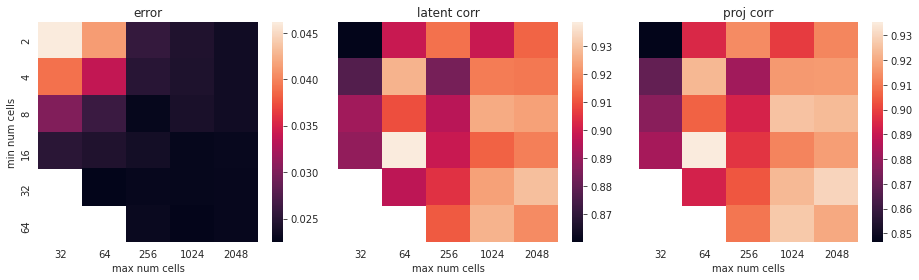

In [158]:
fig, axes = plt.subplots(1, 3, figsize=(13, 4), sharex='all', sharey='all')

sns.heatmap(errors, xticklabels=max_ncs, yticklabels=min_ncs, ax=axes[0])
sns.heatmap(latent_corrs, xticklabels=max_ncs, yticklabels=min_ncs, ax=axes[1])
sns.heatmap(proj_corrs, xticklabels=max_ncs, yticklabels=min_ncs, ax=axes[2])

axes[0].set_title('error')
axes[1].set_title('latent corr')
axes[2].set_title('proj corr')

axes[0].set_ylabel('min num cells')
axes[0].set_xlabel('max num cells')
axes[1].set_xlabel('max num cells')
axes[2].set_xlabel('max num cells')

fig.tight_layout()
plt.show()

In [166]:
n_seeds = 20
seeds = [int(2 ** i) for i in range(n_seeds)]
n_samples = int(1e2)
sigma = 0.1

num_expts = [5, 10, 15, 20, 25, 30, 25]
min_ncs = [2, 64]
max_ncs = [32, 1024]

df = pd.DataFrame()
for seed in tqdm(seeds):
    z_train, z_test = get_source_signal(n_samples, np.random.RandomState(seed))
    for min_num_cells in tqdm(min_ncs, leave=False):
        for max_num_cells in tqdm([item for item in max_ncs if item > min_num_cells], leave=False):
            for num_expt in tqdm(num_expts, leave=False):

                # create sim
                sim = create_cca_simulation(
                    z_train=z_train,
                    z_test=z_test,
                    num_expts=num_expt,
                    min_num_cells=min_num_cells,
                    max_num_cells=max_num_cells,
                    n_samples=n_samples,
                    sigma=sigma,
                    seed=seed,
                )

                # fit cca
                cca = rcca.CCA(kernelcca=True, ktype='linear', reg=0.1, numCC=2, verbose=False)
                cca.train(sim['x_train'])

                # get avg error
                testcorrs = cca.validate(sim['x_test'])
                mean_corr = np.mean([item.mean() for item in testcorrs])
                error = 1 - mean_corr

                # get avg proj corr
                corrs_all = []
                for c in range(num_expt):
                    cos_sim = np.zeros((2, 2))
                    for i in range(2):
                        for j in range(2):
                            cos_sim[i, j] = cos_similarity(sim['proj_mats'][c][:, i], cca.ws[c][:, j])
                    _corrs = np.max(np.abs(cos_sim), axis=0)
                    corrs_all.append(np.mean(_corrs))
                avg_proj_corr = np.mean(corrs_all)

                # get avg latent corr
                latent_corrs = []
                for comp in cca.comps:
                    _corrs = np.abs(
                        [pearsonr(sim['z_train'][:, i], comp[:, j])[0]
                         for i in range(2) for j in range(2)]
                    )
                    _idxs = np.argsort(_corrs)
                    latent_corrs.append(np.mean(_corrs[_idxs[-2:]]))
                avg_latent_corr = np.mean(latent_corrs)

                results = {
                    'seed': [seed],
                    'error': [error],
                    'proj_corr': [avg_proj_corr],
                    'latent_corr': [avg_latent_corr],
                    'min_num_cells': [min_num_cells],
                    'max_num_cells': [max_num_cells],
                    'num_expts': [num_expt],
                }
                df = pd.concat([df, pd.DataFrame.from_dict(results)])
df = reset_df(df)

In [ ]:
min_ncs = [2, 64]
max_ncs = [32, 1024]

<AxesSubplot:xlabel='num_expts', ylabel='latent_corr'>

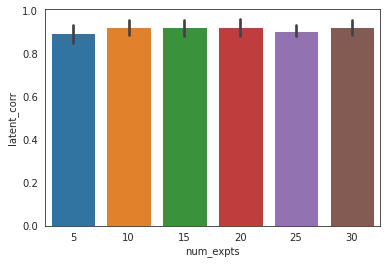

In [178]:
selected_df = df.loc[(df.min_num_cells == 2) & (df.max_num_cells == 32)]
selected_df = df.loc[(df.min_num_cells == 64) & (df.max_num_cells == 1024)]
sns.barplot(data=selected_df, x='num_expts', y='latent_corr')


In [167]:
df

,seed,error,proj_corr,latent_corr,min_num_cells,max_num_cells,num_expts
0,1,0.039396,0.837462,0.861658,2,32,5
1,1,0.090387,0.937068,0.933139,2,32,10
2,1,0.131916,0.984571,0.963220,2,32,15
3,1,0.088203,0.961541,0.964669,2,32,20
4,1,0.099902,0.976318,0.978408,2,32,25
...,...,...,...,...,...,...,...
415,524288,0.022374,0.964073,0.962613,64,1024,15
416,524288,0.023422,0.959549,0.958306,64,1024,20
417,524288,0.022446,0.957551,0.956151,64,1024,25
418,524288,0.023268,0.955034,0.953940,64,1024,30


## PLS

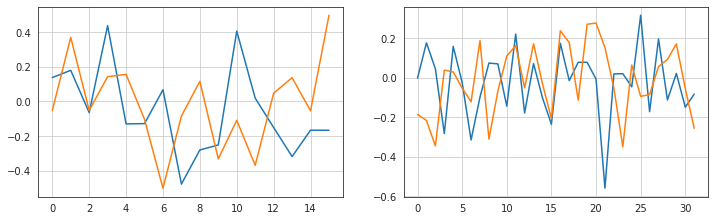

In [23]:
dim_x, dim_y = 16, 32
sigma_x, sigma_y = 0.0, 0.0

P = np.random.randn(dim_x, 2)
#P[:, 1] = np.cross(P[:, [0]], P[:, [1]])
Q = np.random.randn(dim_y, 2)
P, Q = tuple(map(orthogonalize, [P, Q]))

E = np.random.randn(n_samples, dim_x) * sigma_x
F = np.random.randn(n_samples, dim_y) * sigma_y

x = z @ P.T + E
y = z @ Q.T + F

x_test = z_test @ P.T + E
y_test = z_test @ Q.T + F


plt.figure(figsize=(12, 3.5))
plt.subplot(121)
plt.plot(P)
plt.grid()
plt.subplot(122)
plt.plot(Q)
plt.grid()
plt.show()

In [24]:
from scipy import spatial

I = P[:, 0]
II = P[:, 1]
cos_sim = 1 - spatial.distance.cosine(I, II)

print(norm(P, axis=0), cos_sim)

[1. 1.] 0.0


In [25]:
I = Q[:, 0]
II = Q[:, 1]
cos_sim = 1 - spatial.distance.cosine(I, II)

print(norm(Q, axis=0), cos_sim)

[1. 1.] 0.0


In [26]:
from sklearn.cross_decomposition import PLSCanonical

pls = PLSCanonical(
    n_components=2,
    scale=True,
    algorithm='svd',
    max_iter=50000,
    tol=1e-15,
).fit(x, y)
T, U = pls.transform(x, y)
pls.score(x_test, y_test)

0.8992261519138769

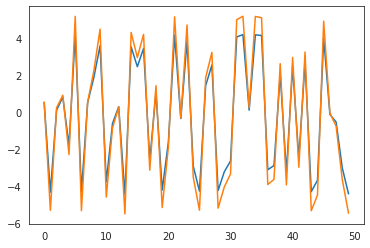

In [27]:
plt.plot(T[:50, 0])
plt.plot(U[:50, 0])

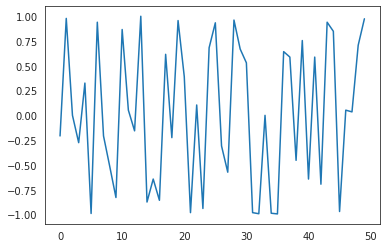

In [28]:
plt.plot(z[:50, 0])

In [29]:
from scipy import spatial

dataSetI = T[:, 0]
dataSetII = U[:, 0]

result = 1 - spatial.distance.cosine(dataSetI, dataSetII)
result

0.9998251824586186

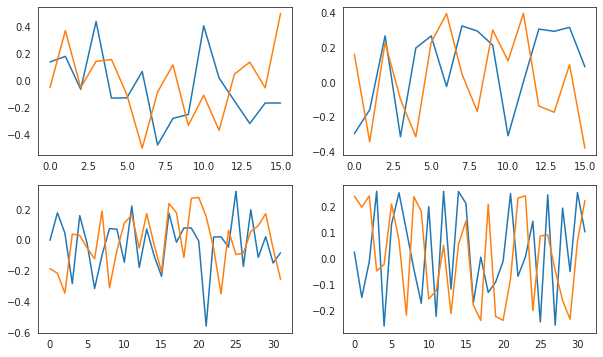

In [30]:
plt.figure(figsize=(10, 6))

plt.subplot(221)
plt.plot(P)
plt.subplot(222)
plt.plot(pls.x_loadings_)
plt.subplot(223)
plt.plot(Q)
plt.subplot(224)
plt.plot(pls.y_loadings_)

plt.show()

In [31]:
from scipy import spatial

I = Q[:, 0]
II = Q[:, 1]

result = 1 - spatial.distance.cosine(I, II)
result

0.0

In [32]:
I = pls.y_loadings_[:, 0]
II = pls.y_loadings_[:, 1]

result = 1 - spatial.distance.cosine(I, II)
result

0.02049339683389928

In [33]:
np.rad2deg(np.arccos(result))

88.82573264908198

## CCA

In [49]:
import rcca

cca = rcca.CCA(kernelcca=True, ktype='linear', reg=1.0, numCC=2)

In [50]:
cca.train([x, y])

Training CCA, kernel = linear, regularization = 1.0000, 2 components


In [51]:
testcorrs = cca.validate([x_test, y_test])
testcorrs

[array([0.99975779, 0.99949445, 0.99716948, 0.99742545, 0.99714784,
        0.99717948, 0.99876482, 0.99822929, 0.99966171, 0.99843138,
        0.99998712, 0.99920971, 0.9999271 , 0.99960872, 0.99742675,
        0.99770802]),
 array([0.99999595, 0.99744655, 0.99968608, 0.99991307, 0.99961767,
        0.9983968 , 0.99874959, 0.99793154, 0.99922509, 0.99750652,
        0.99786734, 0.9975504 , 0.99918006, 0.99866182, 0.99911243,
        0.99733046, 0.99749114, 0.99982285, 0.99757084, 0.99930094,
        0.99995306, 0.99955876, 0.99865336, 0.99990081, 0.99748978,
        0.99945325, 0.99827828, 0.99921284, 0.99775211, 0.99990282,
        0.99882347, 0.99910412])]

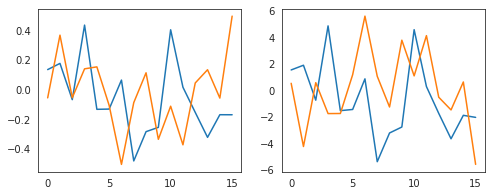

In [52]:
plt.figure(figsize=(8, 3))

plt.subplot(121)
plt.plot(P)

plt.subplot(122)
plt.plot(cca.ws[0])

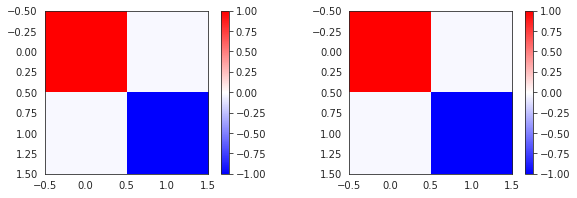

In [53]:
cos_sim1 = np.zeros((2, 2))
cos_sim2 = np.zeros((2, 2))

for i in range(2):
    for j in range(2):
        cos_sim1[i, j] = 1 - spatial.distance.cosine(P[:, i], cca.ws[0][:, j])
        cos_sim2[i, j] = 1 - spatial.distance.cosine(Q[:, i], cca.ws[1][:, j])

plt.figure(figsize=(10, 3))
plt.subplot(121)
plt.imshow(cos_sim1, cmap='bwr', vmin=-1, vmax=1)
plt.colorbar()
plt.subplot(122)
plt.imshow(cos_sim2, cmap='bwr', vmin=-1, vmax=1)
plt.colorbar()
plt.show()

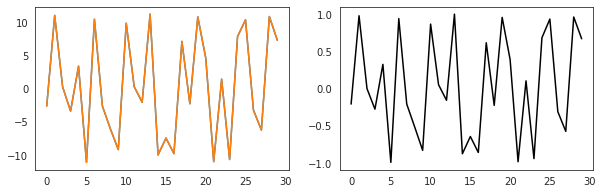

In [54]:
plt.figure(figsize=(10, 3))

plt.subplot(121)
plt.plot(cca.comps[0][:30, 0])
plt.plot(cca.comps[1][:30, 0])
plt.subplot(122)
plt.plot(z[:30, 0], c='k')

In [55]:
ev = cca.compute_ev([x_test, y_test])

Computing explained variance for component #1
Computing explained variance for component #2


In [56]:
ev[0].shape, ev[1].shape

((2, 16), (2, 32))

In [57]:
ev[1]

array([[1.01537745e+01, 2.76303264e+00, 2.18239931e+00, 1.82606643e+00,
        1.02492607e+01, 1.06713083e+02, 9.47814630e-01, 6.32696381e+00,
        2.55511789e+00, 3.36492603e+01, 7.95345892e+00, 2.59705831e+00,
        7.04632180e+00, 9.03207947e+00, 2.66228865e+01, 1.65859692e+00,
        2.41670421e+00, 1.08852991e+01, 1.62943797e+01, 3.35113271e+00,
        4.18856926e+00, 5.88190957e-01, 1.13878382e+02, 2.26422827e+00,
        5.39300889e+01, 1.02262549e+00, 6.68381947e+00, 5.61154725e+00,
        1.35268682e+01, 1.14934829e+01, 1.05210942e+01, 3.65258525e+00],
       [7.52514068e+00, 2.52449027e+00, 8.41069580e-01, 3.45467625e+00,
        1.35541443e+01, 1.07011761e+02, 2.03125643e+00, 5.46966949e+00,
        1.31869702e+00, 3.51328153e+01, 8.80014754e+00, 3.28578212e+00,
        9.45738258e+00, 7.96380661e+00, 3.12726584e+01, 2.03367785e+00,
        2.26489055e+00, 8.48137908e+00, 1.59210771e+01, 2.30377728e+00,
        2.34235868e+00, 7.77923546e-02, 1.12756618e+02, 8.04649